# Phase 4 Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re
import nltk
import random
from os import path
from PIL import Image
from nltk import word_tokenize, pos_tag
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer, TweetTokenizer, word_tokenize
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipe

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, \
classification_report, accuracy_score, precision_score, plot_confusion_matrix

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sw = stopwords.words('english')

In [4]:
df = pd.read_csv('/Users/meaghanross/Documents/Flatiron/Phase4/NLP_project/data/tweet_product_company.csv', encoding='latin1' )

In [5]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [6]:
df.shape

(9093, 3)

In [7]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [8]:
df.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

To do

2) Fill nas for the brand
3) Label encode the target 
6) dropping 'I can't tell'
7) drop duplicates


In [9]:
df['target']=df['is_there_an_emotion_directed_at_a_brand_or_product']

In [10]:
df.drop('is_there_an_emotion_directed_at_a_brand_or_product',axis=1, inplace=True)

In [11]:
df['text']=df['tweet_text']

In [12]:
df.drop('tweet_text',axis=1, inplace=True)

In [13]:
df['length']= df['text'].str.len()

In [14]:
df.shape

(9093, 4)

__Drop Duplicates__

In [15]:
df.duplicated().sum()

22

In [16]:
df.drop_duplicates(inplace=True)

In [17]:
df.shape

(9071, 4)

In [18]:
df.dropna(subset=['text'], inplace=True)

In [19]:
df.target.value_counts()

No emotion toward brand or product    5375
Positive emotion                      2970
Negative emotion                       569
I can't tell                           156
Name: target, dtype: int64

In [20]:
df.text.isna().sum()

0

# EDA

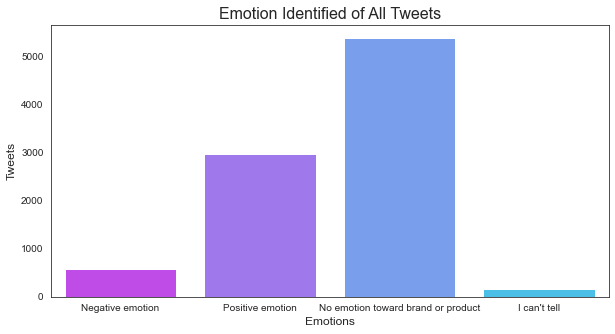

In [21]:
plt.figure(figsize = (10,5))
sns.set_style("white")
all_count_viz = sns.countplot(x=df['target'], palette='cool_r')
all_count_viz.set_title('Emotion Identified of All Tweets',fontsize = 16)
all_count_viz.set_xlabel('Emotions',fontsize = 12)
all_count_viz.set_ylabel('Tweets',fontsize = 12)
plt.show()

In [120]:
df_for_graph = df.loc[df["target"] != "I can't tell"]

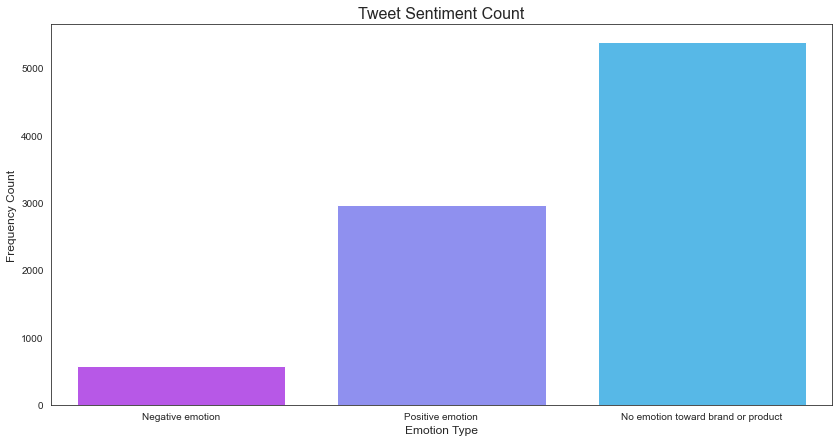

In [126]:
plt.figure(figsize = (14,7))
graph_emotion_type = sns.countplot(x="target", palette="cool_r", data=df_for_graph)
graph_emotion_type.set_title("Tweet Sentiment Count", fontsize = 16)
graph_emotion_type.set_xlabel("Emotion Type", fontsize = 12)
graph_emotion_type.set_ylabel("Frequency Count", fontsize = 12);

__What is the distribution of the emotion of tweets?__

We can see in the data that a majority of the tweets are categorized as those with no emotion with a much smaller portion being coded as having negative emotion. 

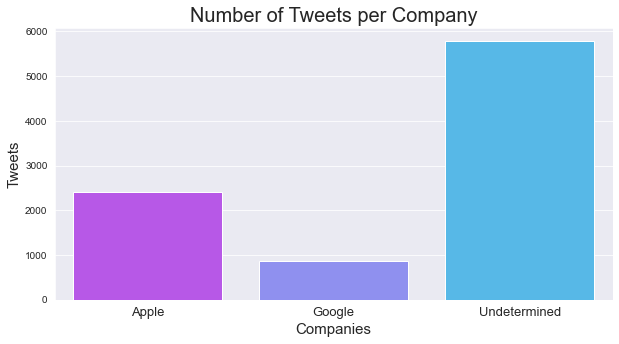

In [22]:
apple_products = ('iPhone', 'iPad or iPhone App', 'iPad','Apple','Other Apple product or service')
google_products = ('Google','Android','Android App','Other Google product or service')
def brand(x):
    if x in apple_products:
        return 'Apple'
    if x in google_products:
        return 'Google'
    else:
        return 'Undetermined'
df['brand'] = df['emotion_in_tweet_is_directed_at'].apply(brand)

# Plot resulting counts of tweet targets
plt.figure(figsize = (10,5))
sns.set_style("darkgrid")
brand_viz = sns.countplot(x=df['brand'], palette = 'cool_r')
brand_viz.set_title('Number of Tweets per Company',fontsize = 20)
brand_viz.set_xlabel('Companies',fontsize = 15)
brand_viz.set_ylabel('Tweets',fontsize = 15)
brand_viz.set_xticklabels(['Apple','Google', 'Undetermined'],fontsize = 13)
plt.show()

__What is the distribution of tweets by company?__

While not the focus of modeling, it's helpful to know the breakdown of tweets by company. There is a large amount of undetermined, which matches up with the data description that says the tweets were only marked with a product or brand if there was a positive or negative emotion identified. The number of undetermined matches the number of tweets classified as `No emotion` or `I can't tell`

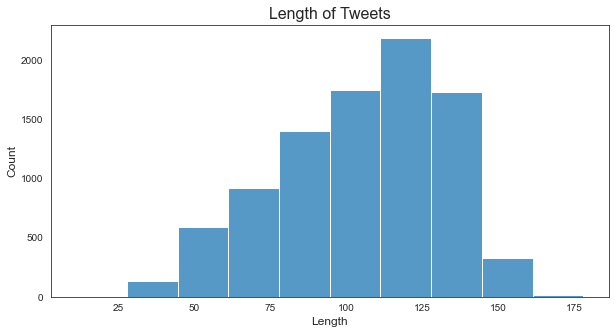

In [109]:
plt.figure(figsize = (10,5))
sns.set_style("white")
brand_viz = sns.histplot(df['length'], bins=10)
brand_viz.set_title('Length of Tweets',fontsize = 16)
brand_viz.set_xlabel('Length',fontsize = 12)
brand_viz.set_ylabel('Count',fontsize = 12)
plt.show()
#fig.savefig('images/length_of_tweet_hist.png');

In [140]:
length_data = df.loc[(df["target"] == "Positive emotion")|(df["target"] == "Negative emotion")]

In [141]:
length_data.head()

,emotion_in_tweet_is_directed_at,target,text,length,brand,tokenized
0,iPhone,Negative emotion,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,127.0,Apple,. @wesley83 3g iphone . 3 hr tweet #rise_austi...
1,iPad or iPhone App,Positive emotion,@jessedee Know about @fludapp ? Awesome iPad/i...,139.0,Apple,@jessedee know @fludapp ? awesome ipad / iphon...
2,iPad,Positive emotion,@swonderlin Can not wait for #iPad 2 also. The...,79.0,Apple,@swonderlin wait #ipad 2 also . sale #sxsw .
3,iPad or iPhone App,Negative emotion,@sxsw I hope this year's festival isn't as cra...,82.0,Apple,@sxsw hope year's festival crashy year's iphon...
4,Google,Positive emotion,@sxtxstate great stuff on Fri #SXSW: Marissa M...,131.0,Google,@sxtxstate great stuff fri #sxsw : marissa may...


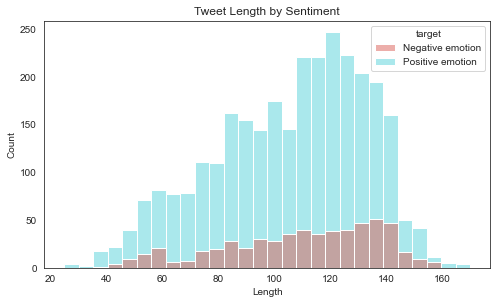

In [146]:
length_data = df.loc[(df["target"] == "Positive emotion")|(df["target"] == "Negative emotion")]
f = plt.figure(figsize=(8,10))
ax = f.add_subplot(2,1,1)

sns.histplot(data=length_data, ax=ax, stat='count', multiple="layer",
             x="length", kde=False,
             palette="hls", hue="target",
             element="bars", legend=True)
ax.set_title("Tweet Length by Sentiment")
ax.set_xlabel("Length")
ax.set_ylabel("Count");

__What is the distribution of the length of tweets?__

Tweets range from 11 characters to 178 characters in length. The tweet length skews slightly left indicating that overall tweets tend to have more characters.

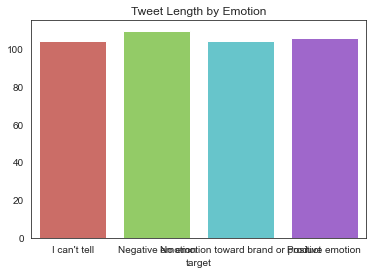

In [119]:
grouped_target = df.groupby('target')['length'].mean()
sns.barplot(x = grouped_target.index, y = grouped_target.values,palette='hls').set_title('Tweet Length by Emotion');

## Preparing the Tweets

In [23]:
sw = stopwords.words('english')

In [24]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [25]:
def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: a document from the review corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    tweet_token = TweetTokenizer()
    doc = tweet_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
#     stemmer = PorterStemmer() 
#     doc = [stemmer.stem(word) for word in doc]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [26]:
df['tokenized'] = df['text'].apply(doc_preparer)

In [158]:
df.sample(3)

,emotion_in_tweet_is_directed_at,target,text,length,brand,tokenized
3180,Other Google product or service,Positive emotion,Grateful for my ACLU/google earplugs right about now #sxsw,58.0,Google,grateful aclu / google earplug right #sxsw
8350,NaN,No emotion toward brand or product,Gary is starting a new show &quot;Daily Grape&quot; for #iPhone only @mention #thankyouecon #SXSW,98.0,Undetermined,"gary start new show "" daily grape "" #iphone @mention #thankyouecon #sxsw"
1989,NaN,No emotion toward brand or product,@mention and I did a &quot;south by&quot; drive-by for this baby!! What an adventure!! #sxsw #iPad #fb {link},110.0,Undetermined,"@mention "" south "" drive-by baby ! ! adventure ! ! #sxsw #ipad #fb { link }"


In [225]:
pd.set_option('display.max_colwidth', None)
df[['target','text', 'tokenized']].head(5)

,target,text,tokenized
0,Negative emotion,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",". @wesley83 3g iphone . 3 hr tweet #rise_austin , dead ! need upgrade . plugin station #sxsw ."
1,Positive emotion,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW","@jessedee know @fludapp ? awesome ipad / iphone app likely appreciate design . also , they're give free t #sxsw"
2,Positive emotion,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,@swonderlin wait #ipad 2 also . sale #sxsw .
3,Negative emotion,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,@sxsw hope year's festival crashy year's iphone app . #sxsw
4,Positive emotion,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)","@sxtxstate great stuff fri #sxsw : marissa mayer ( google ) , tim o'reilly ( tech book / conference ) & matt mullenweg ( wordpress )"


__Train-Test Split__

In [28]:
X = df['tokenized']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    random_state=42,
                                                    stratify=y)

In [29]:
X_train.shape

(6802,)

__Data Cleaning__

For cleaning we want to drop 'I can't tell' after merging `X_train` with `y_train` and `X_test` with `y_test` to and Label Encode the target to numerical data.

In [30]:
df_train=pd.concat([X_train, y_train], axis=1)
df_test=pd.concat([X_test, y_test], axis=1)

In [31]:
y_train.value_counts()

No emotion toward brand or product    4031
Positive emotion                      2227
Negative emotion                       427
I can't tell                           117
Name: target, dtype: int64

In [32]:
df_train.head()

,tokenized,target
2769,want one ! ! rumor : apple open temporary stor...,Positive emotion
2787,#aapl already big winner #sxsw { link } #in,No emotion toward brand or product
7021,@mention google's disavowal plan launch #sxsw .,No emotion toward brand or product
4882,anyone go buy new ipad donate #japan #tsunami ...,I can't tell
715,{ link } part presentation #sxsw good thing cr...,Positive emotion


In [33]:
def drop_unidentified(df):
    '''
    Drop rows from DataFrame where the target is 'I can't tell'.
    '''
    df.drop(df.loc[df['target']=="I can't tell"].index, inplace=True)
    return df

In [34]:
def label(df):
    '''
    Encode values of the target to numerical data.
    '''
    df['target'] = df['target'].map({'No emotion toward brand or product': 0,
                                     'Negative emotion': 1,
                                     'Positive emotion': 2})
    return df

In [35]:
cleaning_pipeline = Pipeline(steps=[
    ('drop', FunctionTransformer(drop_unidentified)),
    ('label', FunctionTransformer(label))
])

In [36]:
df_train_clean = cleaning_pipeline.fit_transform(df_train)
df_test_clean = cleaning_pipeline.transform(df_test)

In [37]:
df_test_clean.head()

,tokenized,target
5039,rt @mention : aron pilhofer new york time endo...,0
643,"ok nerd , totally bateman . want sign ipad 2 ?...",0
4451,podcast social business summit 2011 austin { l...,2
177,#winning picture #android #google #sxsw { link },2
4980,team android sxsw  ûò full party detail revea...,2


In [38]:
df_train_clean.target.value_counts()

0    4031
2    2227
1     427
Name: target, dtype: int64

## Model Iterations

In [39]:
def print_cv_scores(pipe, X, y):
    '''
    Runs cross_validate on given feature and multiclass target arrays using given pipeline, 
    printing the scoring results for both training and cross_val.
    '''
    scoring = ['accuracy','precision_macro', 'recall_macro', 'f1_macro']
    
    results = cross_validate(pipe, X, 
                                   y, 
                                   return_train_score=True, scoring=scoring)
    
    print(results['train_accuracy'])
    print('Training Accuracy', results['train_accuracy'].mean())
    print('##############')
    print(results['test_accuracy'])
    print('Cross_Val Accuracy', results['test_accuracy'].mean())
    print('##############')
    print('Training Macro Precision:', results['train_precision_macro'].mean())
    print('Cross_Val Macro Precision:', results['test_precision_macro'].mean())
    print('##############')
    print('Training Macro Recall:', results['train_recall_macro'].mean())
    print('Cross_Val Macro Recall:', results['test_recall_macro'].mean())
    print('##############')
    print('Training Macro F1:', results['train_f1_macro'].mean())
    print('Cross_Val Macro F1:', results['test_f1_macro'].mean())

In [40]:
display_labels = ['No Emotion', 
                  'Negative Emotion', 
                  'Positive Emotion']

def print_cm_with_labels(y_true, 
                         y_pred, 
                         display_labels):
    '''
    Takes the true values and predicted values of a classifier and 
    plots a confusion matrix (normalized by predictions) using 
    a list of given display labels.
    '''
    cm = confusion_matrix(y_true, y_pred, normalize = 'pred')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)

    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax)
    ax.grid(False)
    disp.ax_.set_xticklabels(display_labels,rotation=45);

### FSM

In [41]:
fsm_pipe = Pipeline([('cv', CountVectorizer(stop_words=sw)),
                     ('mnb', MultinomialNB())])

fsm_pipe.fit(df_train_clean['tokenized'], 
             df_train_clean['target'])

Pipeline(steps=[('cv',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('mnb', MultinomialNB())])

In [42]:
print_cv_scores(fsm_pipe, 
                df_train_clean['tokenized'], 
                df_train_clean['target'])

[0.82198953 0.81563201 0.82722513 0.82255049 0.82311144]
Training Accuracy 0.8221017202692595
##############
[0.66866118 0.65893792 0.66791324 0.6828721  0.63575168]
Cross_Val Accuracy 0.66282722513089
##############
Training Macro Precision: 0.8318967646417338
Cross_Val Macro Precision: 0.624752249389291
##############
Training Macro Recall: 0.6870117403070894
Cross_Val Macro Recall: 0.4773316799275314
##############
Training Macro F1: 0.7305050238594571
Cross_Val Macro F1: 0.49500203651448704


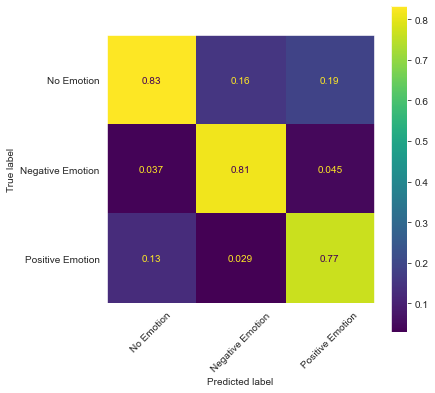

In [43]:
print_cm_with_labels(df_train_clean['target'],
                     fsm_pipe.predict(df_train_clean['tokenized']),
                     display_labels)

## Multinomial Bayes 

In [44]:
bayes_pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words=sw,
                                                 max_features=None)),
                       ('mnb', MultinomialNB())])
bayes_pipe.fit(df_train_clean['tokenized'], 
               df_train_clean['target'])

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('mnb', MultinomialNB())])

In [45]:
print_cv_scores(bayes_pipe, 
                df_train_clean['tokenized'], 
                df_train_clean['target'])

[0.74925206 0.74719521 0.74177263 0.74121167 0.75560957]
Training Accuracy 0.7470082273747195
##############
[0.64173523 0.64323111 0.65968586 0.64622289 0.64023934]
Cross_Val Accuracy 0.6462228870605834
##############
Training Macro Precision: 0.8749168750669354
Cross_Val Macro Precision: 0.5429778269105636
##############
Training Macro Recall: 0.4866022732586677
Cross_Val Macro Recall: 0.3893823487631971
##############
Training Macro F1: 0.49151208127099366
Cross_Val Macro F1: 0.36488458710764066


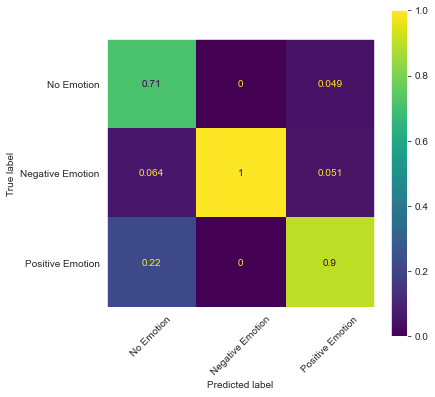

In [46]:
print_cm_with_labels(df_train_clean['target'],
                     bayes_pipe.predict(df_train_clean['tokenized']),
                     display_labels)

In [47]:
len(bayes_pipe[0].vocabulary_)

7270

## Final Model Evaluation

In [48]:
# bayes_pipe.score(df_test_clean['tokenized'], df_test_clean['target'])

In [49]:
# y_true = df_test_clean['target']
# y_pred = bayes_pipe.predict(df_test_clean['tokenized'])

In [50]:
# print_cm_with_labels(df_test_clean['target'],
#                      bayes_pipe.predict(df_test_clean['tokenized']),
#                      display_labels)

In [51]:
# precision_score(y_true, y_pred, average='macro')

### MNB with SMOTE

In [52]:
df_train_clean.target.value_counts()

0    4031
2    2227
1     427
Name: target, dtype: int64

In [84]:
strategy = {0:4031, 1:585, 2:2227}
# strategy = 'SpreadSubsample'
bayes_smote_pipe = imbpipe([
                            ('tfidf', TfidfVectorizer(stop_words=sw)),
                            ('smote', SMOTE(random_state=42,
                                            sampling_strategy=strategy)),
                            ('mnb', MultinomialNB())
])
bayes_smote_pipe.fit(df_train_clean['tokenized'], df_train_clean['target'])

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('smote',
                 SMOTE(random_state=42,
                       sampling_strategy={0: 4031, 1: 585, 2: 2227})),
                ('mnb', MultinomialNB())])

In [85]:
print_cv_scores(bayes_smote_pipe, 
                df_train_clean['tokenized'], 
                df_train_clean['target'])

[0.77038145 0.77094241 0.76869858 0.76477188 0.77486911]
Training Accuracy 0.7699326851159312
##############
[0.64622289 0.65370232 0.66043381 0.66791324 0.65220643]
Cross_Val Accuracy 0.656095736724009
##############
Training Macro Precision: 0.8716368963608548
Cross_Val Macro Precision: 0.7616762305868054
##############
Training Macro Recall: 0.5416279916652635
Cross_Val Macro Recall: 0.4178130752669052
##############
Training Macro F1: 0.5761262988116955
Cross_Val Macro F1: 0.41569810323854783


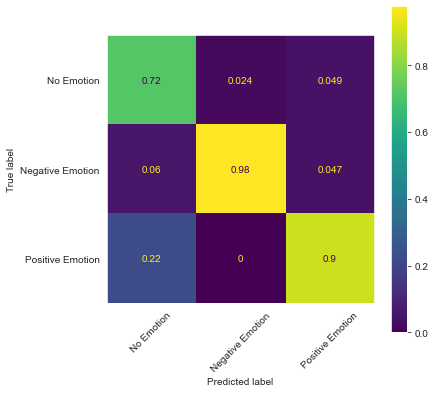

In [86]:
print_cm_with_labels(df_train_clean['target'],
                     bayes_smote_pipe.predict(df_train_clean['tokenized']),
                     display_labels)

## Final Model Evaluation with SMOTE

The model that performs the best on macro precision with 76% on the cross validation scores used Multinomial Bayes after putting the data through a TF-IDF vectorizer and using SMOTE to slightly oversample the negative emotion class. We will now see how this model performs on the unseen data of the testing set.

In [87]:
bayes_smote_pipe.score(df_test_clean['tokenized'], df_test_clean['target'])

0.6599371915657245

In [88]:
y_true = df_test_clean['target']
y_pred = bayes_smote_pipe.predict(df_test_clean['tokenized'])

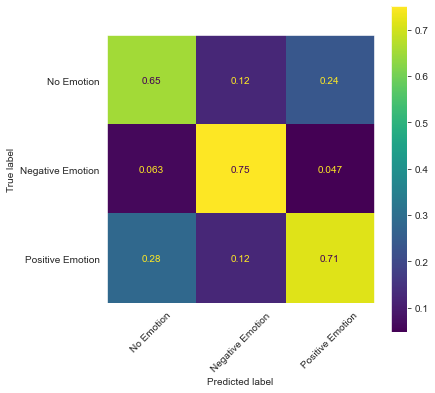

In [89]:
print_cm_with_labels(df_test_clean['target'],
                     bayes_smote_pipe.predict(df_test_clean['tokenized']),
                     display_labels)

In [82]:
precision_score(y_true, y_pred, average='macro')

0.7057536842663273

The model performance drops slightly on the unseen data to 70% on the macro precision score.
As you can see from this confusion matrix above, if you look at the columns of the normalized predictions by class, the final model does the best job at predicting the negative emotion tweets even when that was the smallest proportion of the data. However, the model struggles to correctly predict tweets with no emotion as you can see that only 65% of the tweets predicted to be no emotion actually match the original human coding.

## XGBoost

In [56]:
xgb_pipe = imbpipe(steps=[('tfidf', TfidfVectorizer(stop_words=sw)),
                          ('sm', SMOTE(random_state=42)),
                          ('xgb', XGBClassifier(random_state=42,
                                                max_depth = 16,
                                                n_jobs = -1))])
xgb_pipe.fit(df_train_clean['tokenized'], df_train_clean['target'])

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('sm', SMOTE(random_state=42)),
                ('xgb',
                 XGBClassifier(base_score=0.5,...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth

In [57]:
print_cv_scores(xgb_pipe, df_train_clean['tokenized'], df_train_clean['target'])

[0.98017951 0.98130142 0.98092745 0.97943156 0.97830965]
Training Accuracy 0.9800299177262527
##############
[0.67090501 0.6724009  0.68137622 0.69783096 0.64921466]
Cross_Val Accuracy 0.6743455497382198
##############
Training Macro Precision: 0.9884834593186012
Cross_Val Macro Precision: 0.5941455810517323
##############
Training Macro Recall: 0.9714847767408721
Cross_Val Macro Recall: 0.5152256918032894
##############
Training Macro F1: 0.9796443262701485
Cross_Val Macro F1: 0.5372272275989286


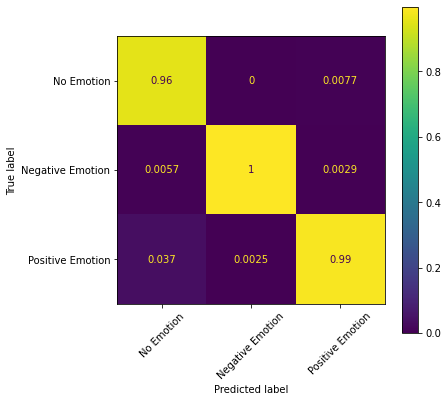

In [58]:
print_cm_with_labels(df_train_clean['target'],
                     xgb_pipe.predict(df_train_clean['tokenized']),
                     display_labels)

In [59]:
# xgb_gs_pipe = imbpipe(steps=[('tfidf', TfidfVectorizer(stop_words=sw, 
#                                                        token_pattern=r'(?u)\b[A-Za-z]+\b')),
#                               ('sm', SMOTE(random_state=42)),
#                               ('xgb', XGBClassifier(random_state=42,
#                                                    n_jobs = -1,
#                                                    max_depth=6,
#                                                    tree_method= 'hist'))])

In [60]:
# param_grid = [{'tfidf__max_features': [5000, None],
#                'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)]}]

# gs_pipe = GridSearchCV(estimator=xgb_gs_pipe, 
#                        param_grid=param_grid, 
#                        verbose=2, 
#                        scoring='precision_macro')

In [61]:
# gs_pipe.fit(df_train_clean['text'], df_train_clean['target'])

In [62]:
# pd.DataFrame(gs_pipe.cv_results_)

In [63]:
# gs_pipe.best_score_

In [64]:
# idf_values = dict(zip(gs_pipe.best_estimator_[0].get_feature_names(), gs_pipe.best_estimator_[0].idf_))
# [print(v) for i, v in enumerate(idf_values.items()) if i < 5]

In [65]:
# max(gs_pipe.best_estimator_[0].idf_)

In [66]:
# rf_SVD_pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words=sw)),
#                           ('svd', TruncatedSVD(n_components=30,
#                                                random_state=42)),
#                           ('rf', RandomForestClassifier(max_depth=12,
#                                                         class_weight='balanced',
#                                                         random_state=42))
# ])

In [67]:
# print_cv_scores(rf_SVD_pipe, df_train_clean['text'], df_train_clean['target'])

In [68]:
# param_grid = [{'svd__n_components': [100, 500, 1000],
#                'rf__max_depth': [5, 10, 15]}]

# gs_pipe = GridSearchCV(estimator=rf_SVD_pipe, 
#                        param_grid=param_grid, 
#                        verbose=2, 
#                        scoring='precision_macro',
#                        return_train_score=True)

In [69]:
# gs_pipe.fit(df_train_clean['text'], df_train_clean['target'])

In [70]:
# pd.DataFrame(gs_pipe.cv_results_)

In [71]:
# plot_confusion_matrix(gs_pipe.best_estimator_, 
#                       df_train_clean['text'], 
#                       df_train_clean['target'],
#                       normalize='pred');

## Word2Vec Model

In [72]:
# from gensim.models import Word2Vec
# from nltk import word_tokenize
# df_train_clean["new_column"] = df_train_clean['text'].str.replace('[^\w\s]','')
# data = df_train_clean['new_column'].map(word_tokenize)

In [73]:
# data[:5]

In [74]:
# model = Word2Vec(data, size=100, window=5, min_count=1, workers=4)

# model.train(data, total_examples=model.corpus_count, epochs=model.epochs)

In [75]:
# wv = model.wv

In [76]:
# wv.most_similar('Apple')

## Word Cloud

In [91]:
pos_text = df['tokenized'].loc[df['target'] == 'Positive emotion'].tolist() 
pos_text = ' '.join(pos_text).lower()

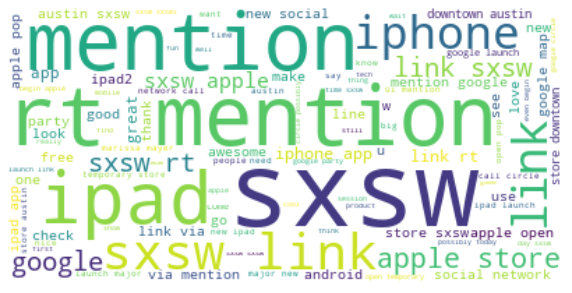

In [92]:
wc = WordCloud(max_font_size=75,
               background_color='white', 
               max_words=100).generate(pos_text)

plt.figure(figsize=(10,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [93]:
neg_text = df['tokenized'].loc[df['target'] == 'Negative emotion'].tolist() 
neg_text = ' '.join(neg_text).lower()

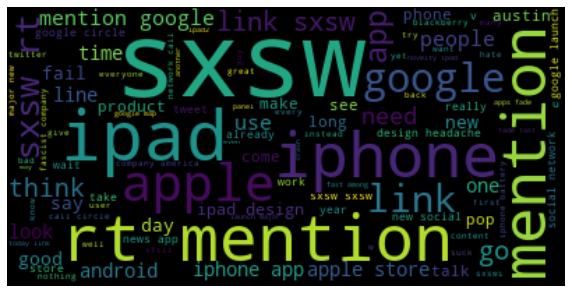

In [94]:
wc = WordCloud(max_font_size=75,
               max_words=100).generate(neg_text)

plt.figure(figsize=(10,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [95]:
neut_text = df['tokenized'].loc[df['target'] == 'No emotion toward brand or product'].tolist() 
neut_text = ' '.join(neut_text).lower()

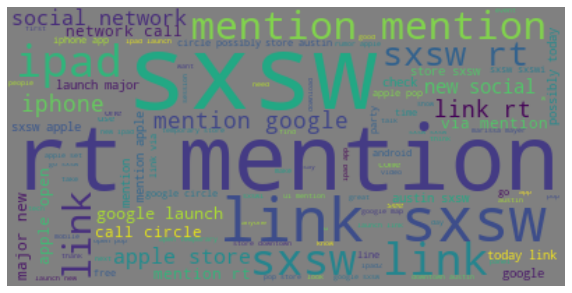

In [96]:
wc = WordCloud(max_font_size=75,
               max_words=100,
               background_color='grey').generate(neut_text)

plt.figure(figsize=(10,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [97]:
regex_token = RegexpTokenizer(r"\w+")

new_pos_text = df['text'].loc[df['target'] == 'Positive emotion'].tolist()
new_pos_text = ' '.join(new_pos_text).lower()
new_pos_text = regex_token.tokenize(new_pos_text)


In [98]:
new_neg_text = df['text'].loc[df['target'] == 'Negative emotion'].tolist()
new_neg_text = ' '.join(new_neg_text).lower()
new_neg_text = regex_token.tokenize(new_neg_text)


In [99]:
new_neut_text = df['text'].loc[df['target'] == 'No emotion toward brand or product'].tolist()
new_neut_text = ' '.join(new_neut_text).lower()
new_neut_text = regex_token.tokenize(new_neut_text)

In [102]:
unique_neg = set(new_neg_text)
unique_pos = set(new_pos_text)
unique_neut = set(new_neut_text)

In [103]:
only_pos= unique_pos.difference(unique_neut.union(unique_neg))
only_pos = ' '.join(only_pos)

In [104]:
only_neg= unique_neg.difference(unique_pos.union(unique_neut))
only_neg = ' '.join(only_neg)

In [105]:
only_neut= unique_neut.difference(unique_pos.union(unique_neg))
only_neut = ' '.join(only_neut)

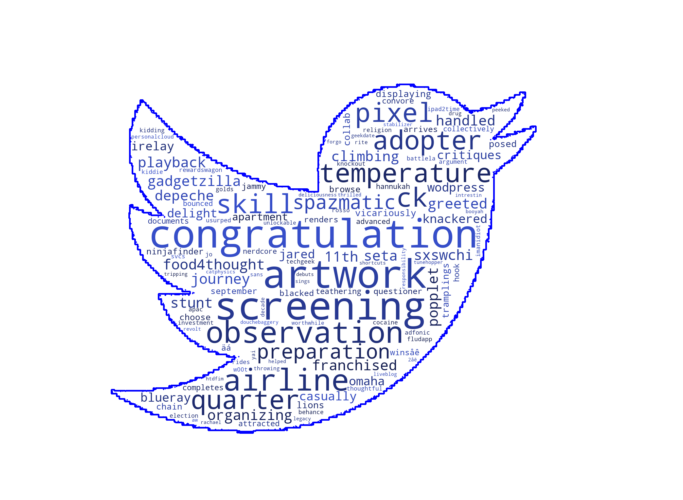

In [110]:
def blue_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 230
    s = int(100.0 * 150.0 / 255.0)
    l = int(100.0 * float(random_state.randint(50, 130)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
mask = np.array(Image.open(path.join(d, "twitter_logo2.png")))

wc = WordCloud(max_font_size=175, 
               mask=mask, 
               background_color = 'white',
               max_words=125,
               contour_width=5, 
               contour_color='blue',
               color_func = blue_color_func).generate(only_pos)


plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


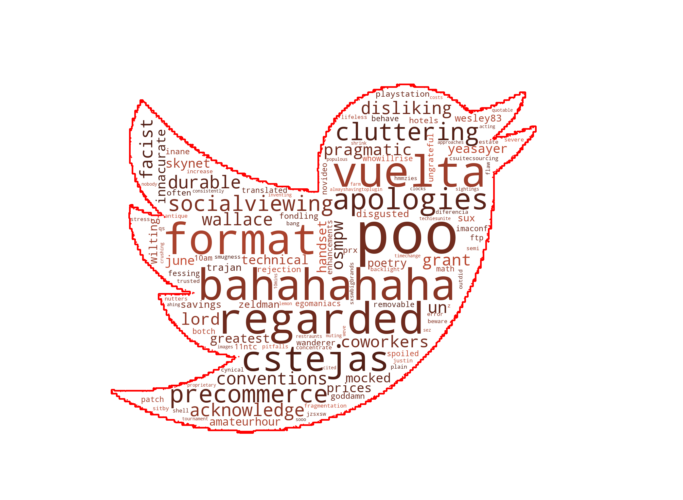

In [111]:
def red_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 10
    s = int(100.0 * 150.0 / 255.0)
    l = int(100.0 * float(random_state.randint(50, 130)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
mask = np.array(Image.open(path.join(d, "twitter_logo2.png")))

wc = WordCloud(max_font_size=175, 
               mask=mask, 
               background_color = 'white',
               max_words=125,
               contour_width=5, 
               contour_color='red',
               color_func=red_color_func).generate(only_neg)


plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

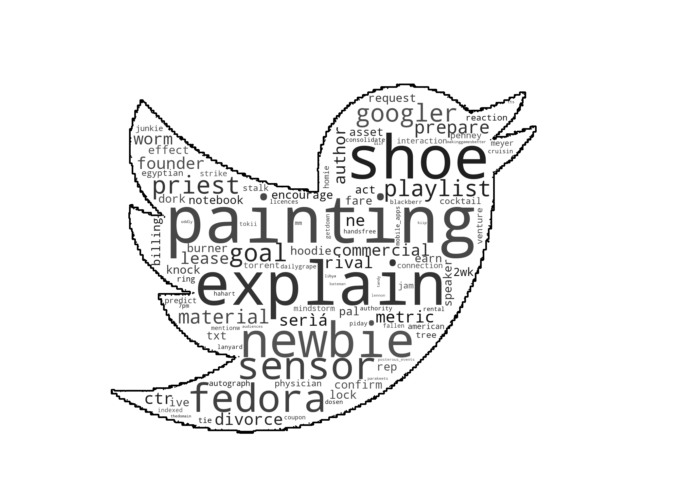

In [112]:
def grey_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 0
    s = int(100.0 * 0.0 / 255.0)
    l = int(100.0 * float(random_state.randint(10, 90)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
mask = np.array(Image.open(path.join(d, "twitter_logo2.png")))

wc = WordCloud(max_font_size=200, 
               mask=mask, 
               background_color = 'white',
               max_words=100,
               contour_width=5, 
               contour_color='black',
               color_func=grey_color_func).generate(only_neut)


plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()